# Running simulations

import required modules and classes

In [22]:
import numpy as np
from pydemic.models.neher import (
    PopulationModel, AgeDistribution, SeverityModel,
    EpidemiologyModel, ContainmentModel, NeherModelSimulation
)
from pydemic import date_to_ms
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.rcParams['font.family'] = [u'serif']
plt.rcParams['font.size'] = 16

def days_to_dates(days):
    from datetime import datetime, timedelta
    return [datetime(2020, 1, 1) + timedelta(float(x)) for x in days]

Load and modify a population model:

In [3]:
from pydemic.data import get_population_model
population = get_population_model('USA-Illinois')

population

{'population_served': 12659682,
 'country': 'United States of America',
 'hospital_beds': 31649,
 'ICU_beds': 1055,
 'initial_cases': 215,
 'imports_per_day': 5.0,
 'cases': 'USA-Illinois'}

We can overwrite these values via

In [4]:
population.initial_cases = 10
population.ICU_beds = 1e10
population.hospital_beds = 1e10
population.imports_per_day = 1.1

population

{'population_served': 12659682,
 'country': 'United States of America',
 'hospital_beds': 10000000000.0,
 'ICU_beds': 10000000000.0,
 'initial_cases': 10,
 'imports_per_day': 1.1,
 'cases': 'USA-Illinois'}

Load an age distribution model:

In [6]:
from pydemic.data import get_age_distribution_model
age_distribution = get_age_distribution_model('United States of America')

age_distribution

{'bin_edges': [0, 10, 20, 30, 40, 50, 60, 70, 80],
 'counts': [39721484,
  42332393,
  46094077,
  44668271,
  40348398,
  42120077,
  38488173,
  24082598,
  13147180]}

Define a severity model, whose values are arrays with one entry per age group:

In [7]:
severity = SeverityModel(
    id=np.array([0, 2, 4, 6, 8, 10, 12, 14, 16]),
    age_group=age_distribution.bin_edges,
    isolated=np.array([0., 0., 0., 0., 0., 0., 0., 0., 0.]),
    confirmed=np.array([5., 5., 10., 15., 20., 25., 30., 40., 50.]),
    severe=np.array([1., 3., 3., 3., 6., 10., 25., 35., 50.]),
    critical=np.array([5., 10., 10., 15., 20., 25., 35., 45., 55.]),
    fatal=np.array([30., 30., 30., 30., 30., 40., 40., 50., 50.]),
)

Define an epidemiology model:

In [8]:
epidemiology = EpidemiologyModel(
    r0=2.7,
    incubation_time=1,
    infectious_period=5,
    length_hospital_stay=7,
    length_ICU_stay=7,
    seasonal_forcing=0.2,
    peak_month=0,
    overflow_severity=2
)

Specify simulation begin and end dates:

In [9]:
start_date = (2020, 2, 23)
end_date = (2020, 11, 1)

Define a containment model:

In [10]:
containment = ContainmentModel(start_date, end_date)
containment.add_sharp_event((2020, 3, 20), factor=.7, dt_days=1)

Create a simulation object and obtain initial conditions:

In [11]:
sim = NeherModelSimulation(
    epidemiology, severity, population.imports_per_day,
    len(age_distribution.counts), containment
)
y0 = sim.get_initial_population(population, age_distribution)

Run the solution. This method uses scipy's adaptive integrators, so we
use the `dense_to_logger` method to resample the output every day.

In [12]:
adaptive_result = sim.solve_deterministic((start_date, end_date), y0)
times = np.arange(adaptive_result.t[0], adaptive_result.t[-1])
result = sim.dense_to_logger(adaptive_result, times)

Plot all the compartments over time:

In [13]:
result.compartments

['dead',
 'exposed',
 'critical',
 'infectious',
 'susceptible',
 'recovered',
 'hospitalized',
 'positive']

In [14]:
plot_compartments = ['infectious',
 'critical',
#  'recovered',
#  'exposed',
#  'dead',
 'hospitalized',
 'susceptible']

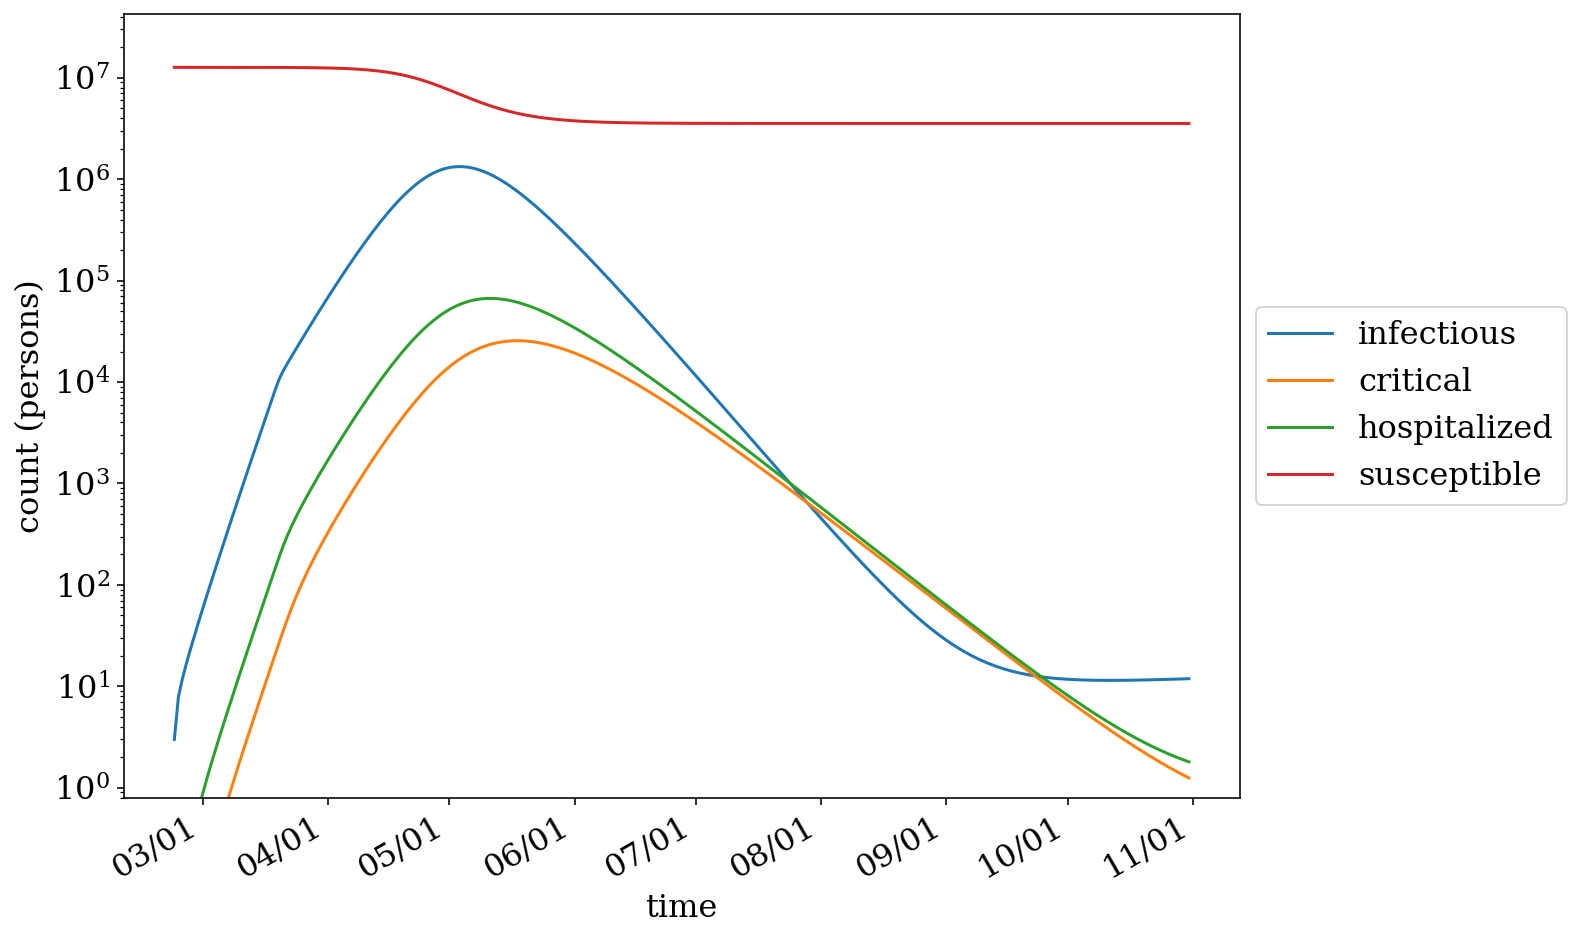

In [23]:
fig, ax = plt.subplots(figsize=(10, 8))

# loop over compartment names (sim.compartments)
for name in plot_compartments:
    ax.plot(days_to_dates(result.t), result.y[name].sum(axis=1), label=name)

# plot on y log scale
ax.set_yscale('log')
ax.set_ylim(ymin=0.8)

# plot x axis as dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
fig.autofmt_xdate()

# create legend
ax.legend(loc='center left', bbox_to_anchor=(1, .5))
ax.set_xlabel('time')
ax.set_ylabel('count (persons)');

Load current case data to compare the model to the actual death counts:

In [24]:
# load reported data
from pydemic.data import united_states
cases = united_states.get_case_data("Illinois")

Plot the death counts against the simulation result.
The containment model is plotted on the bottom panel.

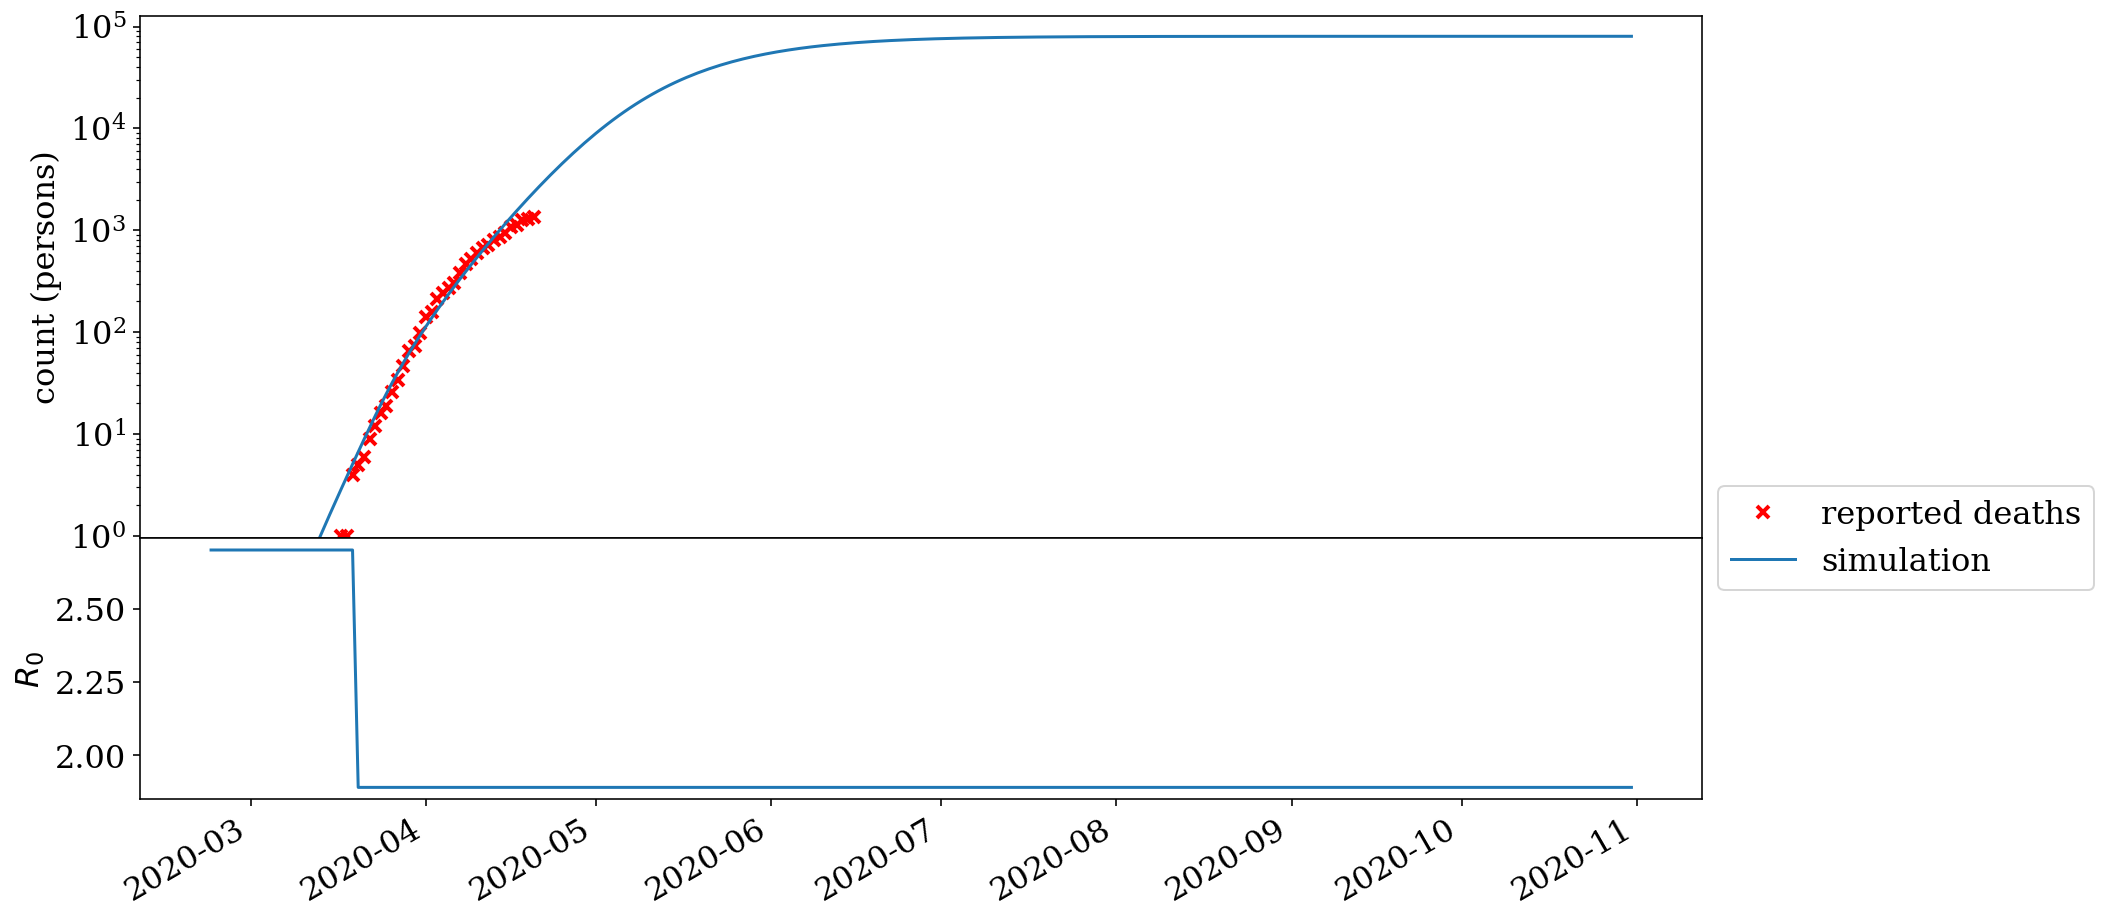

In [27]:
fig = plt.figure(figsize=(14, 8))

import matplotlib.gridspec as gridspec
gspec = gridspec.GridSpec(ncols=1, nrows=3, figure=fig)
ax = [fig.add_subplot(gspec[:2,0]), fig.add_subplot(gspec[2,0])]

ax[0].semilogy(days_to_dates(cases.t), cases.y['dead'],
            'x', c='r', ms=6, markeredgewidth=2,
            label='reported deaths')

ax[0].semilogy(days_to_dates(result.t), result.y['dead'].sum(axis=-1),
            '-', linewidth=1.5, label='simulation')

ax[1].plot(days_to_dates(result.t), 2.7 * containment(result.t),
            '-', linewidth=1.5)

ax[0].set_ylabel("count (persons)")
ax[1].set_ylabel(r'$R_0$')
# ax.set_xlabel("date")
ax[0].set_ylim(.95, .5 * ax[0].get_ylim()[1])
ax[0].legend(bbox_to_anchor=(1, 0), loc='center left')

import matplotlib.dates as mdates
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
fig.autofmt_xdate()
fig.subplots_adjust(hspace=0, wspace=0)
# fig.savefig('neher_best_fit.png')

Save the data to a tsv file of your choosing (`filename`)

In [16]:
def save_data(result, filename):
    from datetime import datetime, timedelta
    dates = [ datetime(2020,1,1)+timedelta(days=x) for x in result.t ]
    compartments = {}
    fp = open(filename, 'w')
    fp.write("time\t")
    for compartment in result.compartments:
        compartments[compartment] = result.y[compartment].sum(axis=-1)
        fp.write(compartment + "\t")
    fp.write("\n")
    for i in range(len(dates)):
        fp.write(dates[i].strftime("%y-%m-%d")+"\t")
        for compartment in compartments:
            fp.write("{0:g}\t".format(compartments[compartment][i]))
        fp.write("\n")
    fp.close()

In [17]:
save_data(result, 'data.tsv')